# NY Person Trip Predictor

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection
import warnings
import math

warnings.filterwarnings('ignore')

In [4]:
#path = "C:/Users/Seant/Desktop/aml_data" #edit this path to change to your path folder

path = "/Users/jayneteo/Dropbox/SMU MITB/Term 2 2021/AML/Project/NHTS/csv" 

household = pd.read_csv("".join([path,'/hhpub.csv']))
person =  pd.read_csv("".join([path,'/perpub.csv']))
trip =  pd.read_csv("".join([path,'/trippub.csv']))

In [5]:
#define function 

def cat_col_prop(data, col):
    print(pd.concat([data[col].value_counts(),
          data[col].value_counts(normalize = True).mul(100)],axis = 1, keys = ('counts','percentage')))

    sns.countplot(data[col], order =  data[col].value_counts().index)

## 1. Merging of Data

### 1.1. Household

In [6]:
#filtering NY Households
ny = household[household['HHSTATE'] == "NY"]

# as only studying hh with car will also filter out hh with HHVEHCNT == 0
ny = ny[ny['HHVEHCNT']>0]

In [7]:
# selection of columns based on prior background inference of potential features
ny = ny[['HOUSEID','HH_CBSA','HOMEOWN','HHSIZE','HHVEHCNT','HHFAMINC','NUMADLT','YOUNGCHILD','WRKCOUNT','MSACAT','MSASIZE','URBAN','URBANSIZE','URBRUR','LIF_CYC']]

### 1.2 Trips

In [8]:
ny_trip = trip[trip['HOUSEID'].isin(ny['HOUSEID'])]

In [9]:
# selecting trips that were done using either 3.Car, 4.SUV, 5.Van
ny_trip = ny_trip[ny_trip['TRPTRANS'].isin([3,4,5])]

In [10]:
# since only 24 lines with trip distance <= 0, removed lines
print('# of trips with dist <=0,', str(sum(ny_trip['TRPMILES']<=0)),' out of', str(len(ny_trip)))
ny_trip = ny_trip[ny_trip['TRPMILES']>0]

# of trips with dist <=0, 22  out of 87307


In [11]:
print(str(sum(ny_trip['TRVLCMIN']<=0)), ' trips missing TRVLCMIN info so will just remove since only ',str(sum(ny_trip['TRVLCMIN']<=0)/len(ny_trip)*100),"%")
ny_trip = ny_trip[ny_trip['TRVLCMIN']>0]

84  trips missing TRVLCMIN info so will just remove since only  0.09623646674686373 %


In [12]:
# Summarise to Person trip counts 
ny_trip_count = ny_trip[['HOUSEID','PERSONID','TRAVDAY']].groupby(['HOUSEID','PERSONID']).agg('count').reset_index().rename(columns = {'TRAVDAY':'n_trips'})

In [13]:
ny_trip_count.head()

,HOUSEID,PERSONID,n_trips
0,30000012,1,9
1,30000082,1,5
2,30000082,2,5
3,30000380,1,3
4,30000380,2,8


## 1.3 People

In [14]:
# filtering people from New York
nyorker = person[person['HOUSEID'].isin(ny['HOUSEID'])]

In [15]:
# selection of columns based on prior background inference of potential features
nyorker = nyorker[['HOUSEID','PERSONID','R_AGE','EDUC','R_RACE','R_SEX','WRK_HOME','WKFTPT','OCCAT','DRIVER','TRAVDAY']]

In [16]:
# merging of Person, Household and Trips to Person
df = nyorker.merge(ny, how = 'left', left_on = 'HOUSEID', right_on = 'HOUSEID')
df = df.merge(ny_trip_count, how = 'left', left_on= ['HOUSEID','PERSONID'], right_on = ['HOUSEID','PERSONID'])

In [17]:
# Replace NA trip counts with 0
df['n_trips'][df['n_trips'].isna()] = 0
#df = df[df['n_trips']>0]
#df = df[df['n_trips']<10]

In [18]:
[c for c in df]

['HOUSEID',
 'PERSONID',
 'R_AGE',
 'EDUC',
 'R_RACE',
 'R_SEX',
 'WRK_HOME',
 'WKFTPT',
 'OCCAT',
 'DRIVER',
 'TRAVDAY',
 'HH_CBSA',
 'HOMEOWN',
 'HHSIZE',
 'HHVEHCNT',
 'HHFAMINC',
 'NUMADLT',
 'YOUNGCHILD',
 'WRKCOUNT',
 'MSACAT',
 'MSASIZE',
 'URBAN',
 'URBANSIZE',
 'URBRUR',
 'LIF_CYC',
 'n_trips']

In [19]:
df.shape

(32292, 26)

## 2. EDA & Feature Engineering 

### 2.1. Train, Test, Split

In [20]:
x_col = [c for c in df if c not in ["HOUSEID","PERSONID","n_trips"]]
x_df = df[x_col]
y_df = df['n_trips']

x_train , x_test, y_train, y_test = model_selection.train_test_split(x_df, y_df, test_size = 0.2, random_state = 888)

In [21]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25833 entries, 11231 to 10750
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   R_AGE       25833 non-null  int64 
 1   EDUC        25833 non-null  int64 
 2   R_RACE      25833 non-null  int64 
 3   R_SEX       25833 non-null  int64 
 4   WRK_HOME    25833 non-null  int64 
 5   WKFTPT      25833 non-null  int64 
 6   OCCAT       25833 non-null  int64 
 7   DRIVER      25833 non-null  int64 
 8   TRAVDAY     25833 non-null  int64 
 9   HH_CBSA     25833 non-null  object
 10  HOMEOWN     25833 non-null  int64 
 11  HHSIZE      25833 non-null  int64 
 12  HHVEHCNT    25833 non-null  int64 
 13  HHFAMINC    25833 non-null  int64 
 14  NUMADLT     25833 non-null  int64 
 15  YOUNGCHILD  25833 non-null  int64 
 16  WRKCOUNT    25833 non-null  int64 
 17  MSACAT      25833 non-null  int64 
 18  MSASIZE     25833 non-null  int64 
 19  URBAN       25833 non-null  int64 
 20  UR

### 2.2. Feature Engineering

#### Age (R_AGE)

62 count of people with no age.  0.00029519289720475033 %.


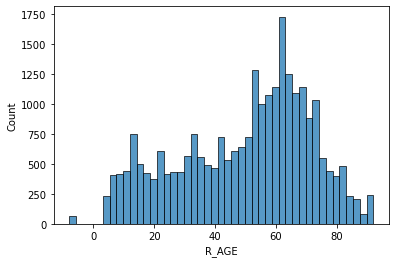

In [22]:
print(str(sum(x_train['R_AGE']<0)), "count of people with no age. ",str(sum(nyorker['R_AGE']<0)/person.shape[0]),"%.")

sns.histplot(x_train['R_AGE'])

# impute missing values (<0) with mean age
mean_age = round(x_train['R_AGE'][x_train['R_AGE']>0].mean())
x_train['R_AGE'][x_train['R_AGE']<0] = mean_age
x_test['R_AGE'][x_test['R_AGE']<0] = mean_age

In [21]:
x_train['AGE_bins']= 'NA'
x_train.loc[x_train['R_AGE'].between(5,15,inclusive = True), 'AGE_bins'] = "5 to 15"
x_train.loc[x_train['R_AGE'].between(16,25,inclusive = True), 'AGE_bins'] = "16 to 25"
x_train.loc[x_train['R_AGE'].between(26,35,inclusive = True), 'AGE_bins'] = "26 to 35"
x_train.loc[x_train['R_AGE'].between(36,45,inclusive = True), 'AGE_bins'] = "36 to 45"
x_train.loc[x_train['R_AGE'].between(46,55,inclusive = True), 'AGE_bins'] = "46 to 55"
x_train.loc[x_train['R_AGE'].between(56,65,inclusive = True), 'AGE_bins'] = "56 to 65"
x_train.loc[x_train['R_AGE'].between(66,75,inclusive = True), 'AGE_bins'] = "66 to 75"
x_train.loc[x_train['R_AGE']>75, 'AGE_bins'] = ">75"

x_test['AGE_bins']= 'NA'
x_test.loc[x_test['R_AGE'].between(5,15,inclusive = True), 'AGE_bins'] = "5 to 15"
x_test.loc[x_test['R_AGE'].between(16,25,inclusive = True), 'AGE_bins'] = "16 to 25"
x_test.loc[x_test['R_AGE'].between(26,35,inclusive = True), 'AGE_bins'] = "26 to 35"
x_test.loc[x_test['R_AGE'].between(36,45,inclusive = True), 'AGE_bins'] = "36 to 45"
x_test.loc[x_test['R_AGE'].between(46,55,inclusive = True), 'AGE_bins'] = "46 to 55"
x_test.loc[x_test['R_AGE'].between(56,65,inclusive = True), 'AGE_bins'] = "56 to 65"
x_test.loc[x_test['R_AGE'].between(66,75,inclusive = True), 'AGE_bins'] = "66 to 75"
x_test.loc[x_test['R_AGE']>75, 'AGE_bins'] = ">75"


          counts  percentage
56 to 65    5689   22.022220
66 to 75    4441   17.191190
46 to 55    3824   14.802772
5 to 15     2492    9.646576
36 to 45    2482    9.607866
26 to 35    2473    9.573027
>75         2351    9.100763
16 to 25    2081    8.055588


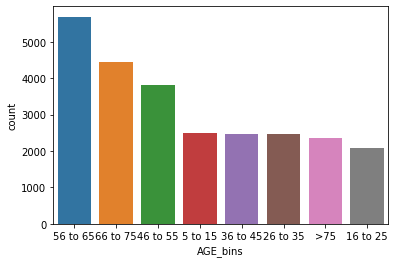

In [22]:
cat_col_prop(x_train,'AGE_bins')

#### Educational Attainment (EDUC)

    counts  percentage
 3    6432   24.898386
 5    5786   22.397708
 2    4990   19.316378
 4    4913   19.018310
-1    1970    7.625905
 1    1723    6.669763
-7      11    0.042581
-8       8    0.030968


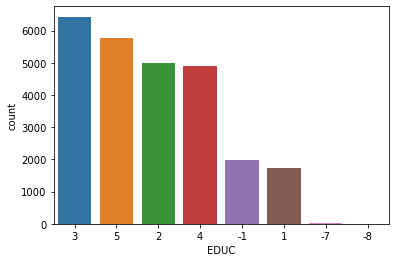

In [23]:
cat_col_prop(x_train,'EDUC')
# approx 8% missing values (<0). To take note of but will addresss in one-hot encoding

#### Race (R_RACE)

     counts  percentage
 1    23152   89.621802
 3      833    3.224558
 2      777    3.007781
 6      550    2.129060
 97     310    1.200015
-7      124    0.480006
 4       57    0.220648
 5       19    0.073549
-8       11    0.042581


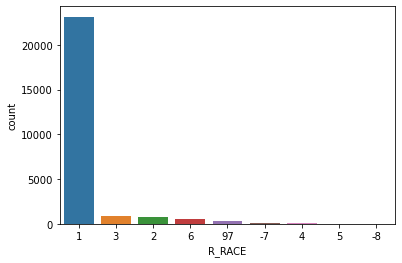

In [24]:
cat_col_prop(x_train,'R_RACE')
# approx 1% missing values (<0). To take note of but will address in one-hot encoding
# Significant proportion of members 'white'

#### Gender (R_SEX)

    counts  percentage
 2   13474   52.158092
 1   12333   47.741261
-7      23    0.089033
-8       3    0.011613


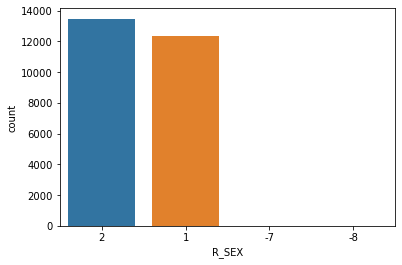

In [25]:
cat_col_prop(x_train, 'R_SEX')
# <1% missing values. To take note but will be addressed in one-hot encoding

#### Work From Home (WRK_HOME)

    counts  percentage
-1   12893   49.909031
 2   11027   42.685712
 1    1391    5.384586
-9     521    2.016800
-7       1    0.003871


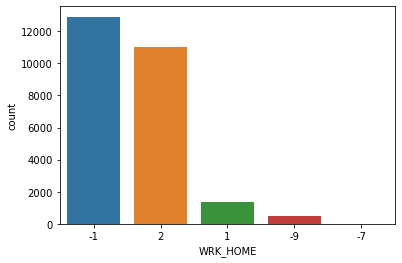

In [26]:
cat_col_prop(x_train,'WRK_HOME')
# Significant proportion -1 (50%) which is the appropriate skip (due to not working) - to address in one-hot

#### Work - Part Time or Full Time (WKFTPT)

    counts  percentage
-1   13414   51.925831
 1    9663   37.405644
 2    2750   10.645299
-7       6    0.023226


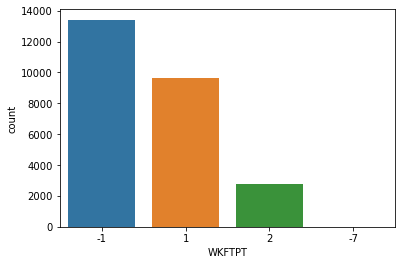

In [27]:
cat_col_prop(x_train,'WKFTPT')
# Significant proportion -1 (52%) which is the appropriate skip (due to not working) - to address in one-hot

#### Job Category (OCCAT)

     counts  percentage
-1    12893   49.909031
 4     6871   26.597763
 1     2642   10.227229
 3     1477    5.717493
 2     1404    5.434909
-9      521    2.016800
 97      18    0.069678
-8        4    0.015484
-7        3    0.011613


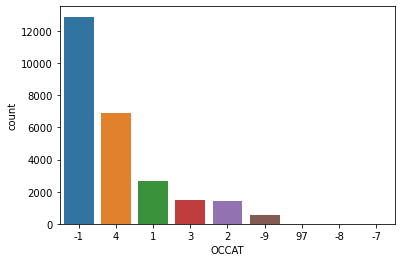

In [28]:
cat_col_prop(x_train,'OCCAT')
# Significant proportion -1 (50%) which is the appropriate skip (due to not working) - to address in one-hot

#### Driver Status (DRIVER)

    counts  percentage
 1   21828   84.496574
-1    2251    8.713661
 2    1754    6.789765


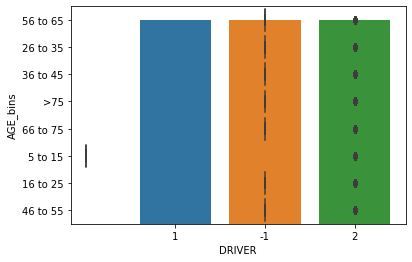

In [29]:
cat_col_prop(x_train,'DRIVER')

#Significant proportion -1 (8.7%) (due to too young) - to address in one-hot encoding
sns.boxplot(data = x_train, x='DRIVER',y='AGE_bins')

#### Travel Day (TRAVDAY)

   counts  percentage
2    3800   14.709867
1    3775   14.613092
7    3766   14.578253
5    3746   14.500832
6    3668   14.198893
3    3595   13.916309
4    3483   13.482755


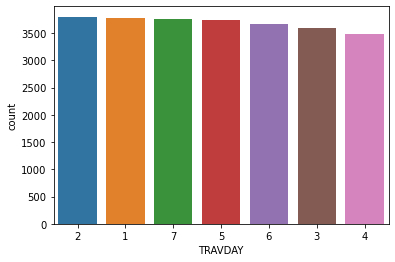

In [30]:
cat_col_prop(x_train,'TRAVDAY')

#### Core Based Statiscal Area FIPS code (HH_CBSA)

       counts  percentage
XXXXX   15330   59.342701
35620    7799   30.190067
40380    1478    5.721364
15380    1226    4.745868


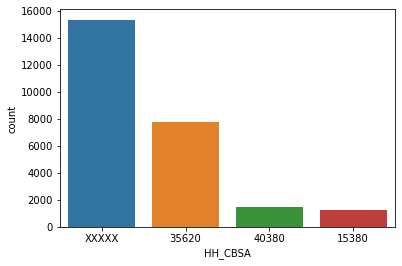

In [31]:
#Core Based Statistical Area (CBSA) FIPS code for the respondent's home address

cat_col_prop(x_train,'HH_CBSA')

# significant number of households under the 'XXXXX=Suppressed, in an MSA of less than 1 million ' category

####  Home Ownership (HOMEOWN)

     counts  percentage
 1    21777   84.299152
 2     3848   14.895676
 97     206    0.797430
-7        2    0.007742


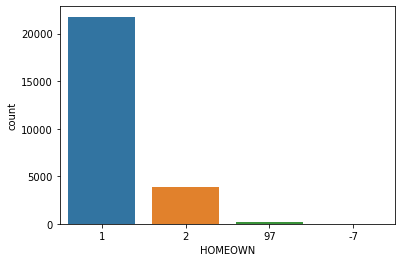

In [32]:
cat_col_prop(x_train,'HOMEOWN')
#Small count with missing value 2. to address in one-hot encoding

#### Household Vehicle Count (HHVEHCNT)

    counts  percentage
2    11491   44.481864
1     6771   26.210661
3     4734   18.325398
4     1790    6.929122
5      672    2.601324
6      244    0.944528
7       82    0.317423
8       23    0.089033
11      12    0.046452
9        9    0.034839
12       5    0.019355
________
new HHVEHCNT
    counts  percentage
2    11491   44.481864
1     6771   26.210661
3     4734   18.325398
>3    2837   10.982077


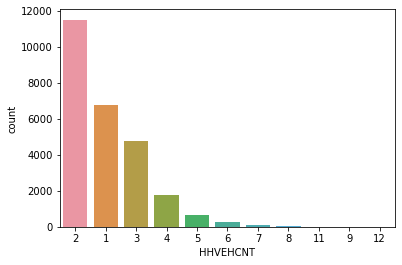

In [33]:
#count of household vehicles

cat_col_prop(x_train,'HHVEHCNT')

# as group size significantly smaller from 4 and above to bin to a single group

x_train['HHVEHCNT'][x_train['HHVEHCNT']>3] = ">3"
x_test['HHVEHCNT'][x_test['HHVEHCNT']>3] = ">3"

print("________")
print("new HHVEHCNT")
print(pd.concat([x_train['HHVEHCNT'].value_counts(),
          x_train['HHVEHCNT'].value_counts(normalize = True).mul(100)],axis = 1, keys = ('counts','percentage'))
    )

#### Family Income (HHFAMINC)

     counts  percentage
 6     4643   17.973135
 7     3807   14.736964
 8     3191   12.352417
 5     2781   10.765300
 4     2017    7.807843
 9     1953    7.560098
 11    1904    7.370418
 10    1812    7.014284
 3     1563    6.050401
-7      748    2.895521
 2      733    2.837456
 1      569    2.202609
-8      111    0.429683
-9        1    0.003871


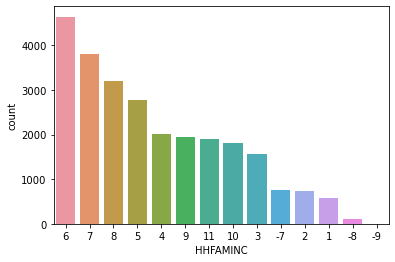

In [34]:
cat_col_prop(x_train,'HHFAMINC')
# approx 3% missing (<0) to address in one-hot encoding

#### Adult Ratio  (NUMADLT)

    counts  percentage
2    16418   63.554368
1     4363   16.889250
3     3503   13.560175
4     1195    4.625866
5      278    1.076143
6       46    0.178067
7       15    0.058065
10       8    0.030968
8        7    0.027097


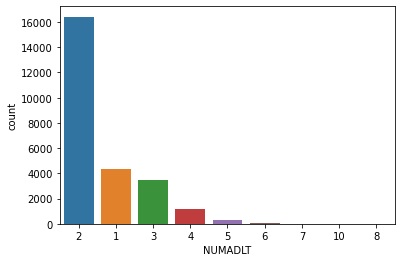

In [35]:
cat_col_prop(x_train, 'NUMADLT')
#no missing values

Before
          counts  percentage
1.000000   17918   69.360895
0.500000    2842   11.001432
0.666667    1983    7.676228
0.400000     888    3.437464
0.750000     669    2.589711
0.333333     503    1.947122
0.600000     375    1.451632
0.800000     213    0.824527
0.250000      95    0.367747
0.285714      80    0.309681
0.714286      50    0.193551
0.833333      36    0.139357
0.428571      35    0.135486
0.571429      31    0.120002
0.375000      20    0.077420
0.625000      19    0.073549
0.222222      17    0.065807
0.200000      17    0.065807
0.444444      11    0.042581
0.700000       9    0.034839
0.166667       7    0.027097
0.142857       6    0.023226
0.857143       5    0.019355
0.363636       4    0.015484

After
      counts  percentage
1      17918   69.360895
>0.5    6232   24.124182
<0.5    1683    6.514923


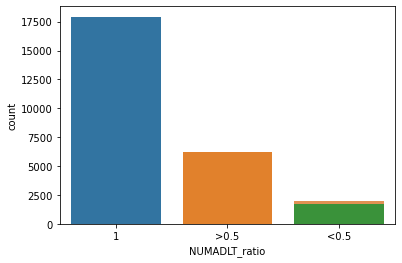

In [36]:
#Convert against proportion of Household size
x_train['NUMADLT'] = x_train['NUMADLT']/x_train['HHSIZE']
x_test['NUMADLT'] = x_test['NUMADLT']/x_test['HHSIZE']
print('Before')
cat_col_prop(x_train,'NUMADLT')
#significant number of varying factors
#to bin into groups
x_train['NUMADLT_ratio'] = 'NA'
x_train.loc[x_train['NUMADLT']==0, 'NUMADLT_ratio'] = '0'
x_train.loc[x_train['NUMADLT'].between(0,0.5,inclusive = False),'NUMADLT_ratio'] = '<0.5'
x_train.loc[x_train['NUMADLT'].between(0.5,1, inclusive = True),'NUMADLT_ratio'] = '>0.5'
x_train.loc[x_train['NUMADLT']==1,'NUMADLT_ratio'] ='1'
print('')
print('After')
cat_col_prop(x_train,'NUMADLT_ratio')


x_test['NUMADLT_ratio'] = 'NA'
x_test.loc[x_test['NUMADLT']==0, 'NUMADLT_ratio'] = '0'
x_test.loc[x_test['NUMADLT'].between(0,0.5,inclusive = False),'NUMADLT_ratio'] = '<0.5'
x_test.loc[x_test['NUMADLT'].between(0.5,1, inclusive = True),'NUMADLT_ratio'] = '>0.5'
x_test.loc[x_test['NUMADLT']==1,'NUMADLT_ratio'] ='1'

#### Young Child Ratio (YOUNGCHILD)

   counts  percentage
0   23583   91.290210
1    1683    6.514923
2     510    1.974219
3      51    0.197422
5       4    0.015484
4       2    0.007742


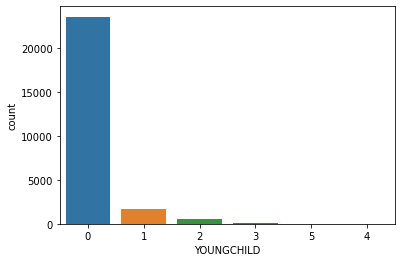

In [37]:
cat_col_prop(x_train,'YOUNGCHILD')

      counts  percentage
0      23583   91.290210
<0.5    1943    7.521387
>0.5     307    1.188402


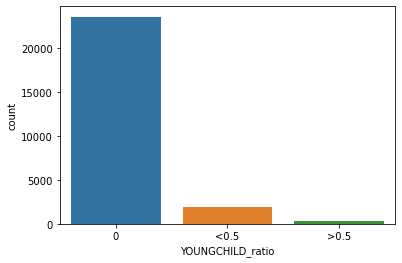

In [38]:
#Convert against proportion of Household size

x_train['YOUNGCHILD'] = x_train['YOUNGCHILD']/x_train['HHSIZE']
x_test['YOUNGCHILD'] = x_test['YOUNGCHILD']/x_test['HHSIZE']

#Bin to groups
x_train['YOUNGCHILD_ratio'] = 'NA'
x_train.loc[x_train['YOUNGCHILD']==0,'YOUNGCHILD_ratio']= '0'
x_train.loc[x_train['YOUNGCHILD'].between(0,0.5,inclusive = False),'YOUNGCHILD_ratio'] = '<0.5'
x_train.loc[x_train['YOUNGCHILD'].between(0.5,1, inclusive = True),'YOUNGCHILD_ratio'] = '>0.5'
x_train.loc[x_train['YOUNGCHILD']==1,'YOUNGCHILD_ratio'] ='1'
 

cat_col_prop(x_train,'YOUNGCHILD_ratio')    

x_test['YOUNGCHILD_ratio'] = 'NA'
x_test.loc[x_test['YOUNGCHILD']==0,'YOUNGCHILD_ratio']= '0'
x_test.loc[x_test['YOUNGCHILD'].between(0,0.5,inclusive = False),'YOUNGCHILD_ratio'] = '<0.5'
x_test.loc[x_test['YOUNGCHILD'].between(0.5,1, inclusive = True),'YOUNGCHILD_ratio'] = '>0.5'
x_test.loc[x_test['YOUNGCHILD']==1,'YOUNGCHILD_ratio'] ='1'
 


#### Worker Count Proportion (WRKCOUNT)

   counts  percentage
2    8892   34.421089
1    7886   30.526846
0    6795   26.303565
3    1702    6.588472
4     491    1.900670
5      56    0.216777
7       7    0.027097
6       4    0.015484


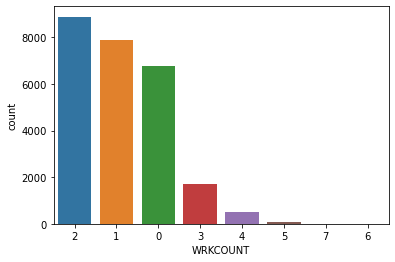

In [39]:
cat_col_prop(x_train,'WRKCOUNT')

      counts  percentage
>0.5    8476   32.810746
0       6795   26.303565
1       6538   25.308714
<0.5    4024   15.576975


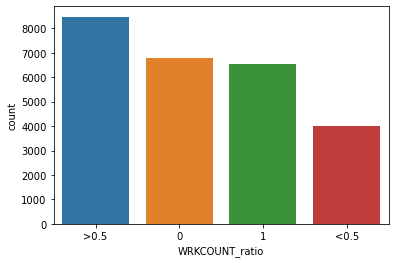

In [40]:
#Convert against proportion of Household size

x_train['WRKCOUNT'] = x_train['WRKCOUNT']/x_train['HHSIZE']
x_test['WRKCOUNT'] = x_test['WRKCOUNT']/x_test['HHSIZE']

#Bin to groups
x_train['WRKCOUNT_ratio'] = 'NA'
x_train.loc[x_train['WRKCOUNT']==0,'WRKCOUNT_ratio']= '0'
x_train.loc[x_train['WRKCOUNT'].between(0,0.5,inclusive = False),'WRKCOUNT_ratio'] = '<0.5'
x_train.loc[x_train['WRKCOUNT'].between(0.5,1, inclusive = True),'WRKCOUNT_ratio'] = '>0.5'
x_train.loc[x_train['WRKCOUNT']==1,'WRKCOUNT_ratio'] ='1'

cat_col_prop(x_train,'WRKCOUNT_ratio')

x_test['WRKCOUNT_ratio'] = 'NA'
x_test.loc[x_test['WRKCOUNT']==0,'WRKCOUNT_ratio']= '0'
x_test.loc[x_test['WRKCOUNT'].between(0,0.5,inclusive = False),'WRKCOUNT_ratio'] = '<0.5'
x_test.loc[x_test['WRKCOUNT'].between(0.5,1, inclusive = True),'WRKCOUNT_ratio'] = '>0.5'
x_test.loc[x_test['WRKCOUNT']==1,'WRKCOUNT_ratio'] ='1'

 

#### Household Size (HHSIZE)

Before
    counts  percentage
2    11103   42.979909
3     4445   17.206674
4     3996   15.468587
1     3744   14.493090
5     1653    6.398792
6      503    1.947122
7      213    0.824527
8      101    0.390973
9       41    0.158712
10      30    0.116131
11       4    0.015484

After
    counts  percentage
2    11103   42.979909
>3    6541   25.320327
3     4445   17.206674
1     3744   14.493090


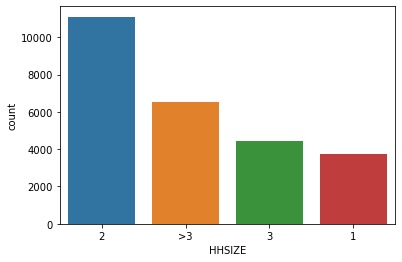

In [41]:
#count of household members
print("Before")
cat_col_prop(x_train,'HHSIZE')

# to bin tail HHSIZE

x_train['HHSIZE'][x_train['HHSIZE']>3] = ">3"

print("")
print("After")

cat_col_prop(x_train,'HHSIZE')

x_test['HHSIZE'][x_test['HHSIZE']>3] = ">3"

#### Metropolitan Statistical Area (MSACAT)


   counts  percentage
3   11149   43.157976
1    7799   30.190067
4    4181   16.184725
2    2704   10.467232


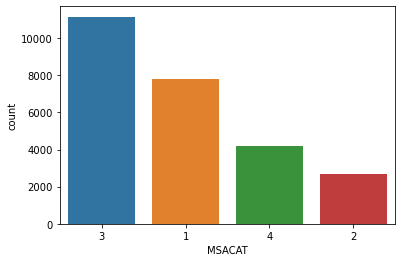

In [42]:
cat_col_prop(x_train,'MSACAT')
             
#no missing values and relatively proportional distribution

#### Population size of MSA (MSASIZE)

   counts  percentage
5    7799   30.190067
1    6507   25.188712
6    4181   16.184725
3    3498   13.540820
4    2704   10.467232
2    1144    4.428444


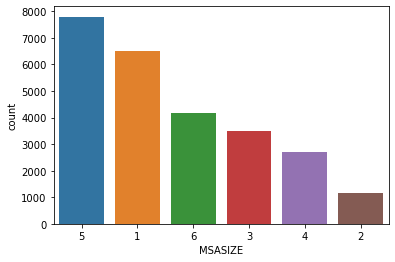

In [43]:
cat_col_prop(x_train,'MSASIZE')
             
#no missing values and relatively proportional distribution

#### House in Urban or Rural Area (URBAN)

Before
   counts  percentage
1   14518   56.199435
4    8775   33.968180
2    2535    9.813030
3       5    0.019355

After
       counts  percentage
urban   17053   66.012465
rural    8780   33.987535


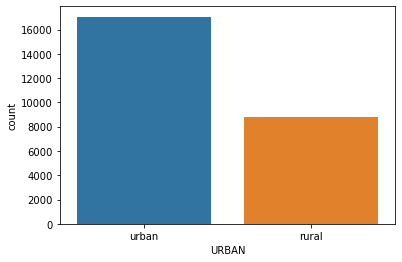

In [44]:
print('Before')
cat_col_prop(x_train,'URBAN')

# combine 1 and 2 (in an urban area and in an urban cluster ) & combine 3 and 4 (surround by urban and not in urban)

x_train['URBAN'][x_train['URBAN'].isin([1,2])] = 'urban'
x_train['URBAN'][x_train['URBAN'].isin([3,4])] = 'rural'

print("")
print('After')

cat_col_prop(x_train, 'URBAN')

x_test['URBAN'][x_test['URBAN'].isin([1,2])] = 'urban'
x_test['URBAN'][x_test['URBAN'].isin([3,4])] = 'rural'

#### URBANSIZE

   counts  percentage
6   11315   43.800565
5    5030   19.471219
1    3961   15.333101
3    2883   11.160144
2    2644   10.234971


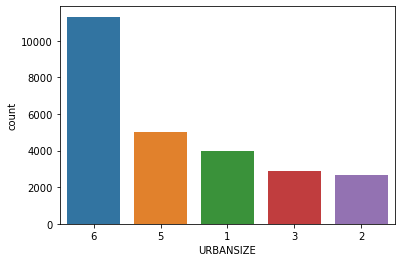

In [45]:
#06 = not in an urbanised area 
#05 - 1 million with heavy rail 

#Relatively proportional classes
cat_col_prop(x_train,'URBANSIZE')

#### URBRUR

   counts  percentage
1   17053   66.012465
2    8780   33.987535


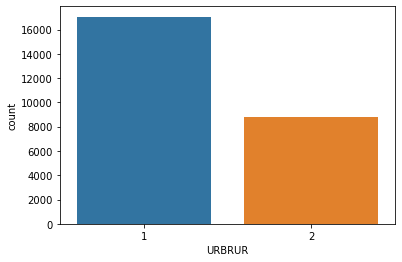

In [46]:
cat_col_prop(x_train,'URBRUR')
# missing values nor disproportion

#### LIF_CYC 

    counts  percentage
10    7113   27.534549
2     5969   23.106105
6     3905   15.116324
4     2551    9.874966
1     1983    7.676228
9     1761    6.816862
8     1691    6.545891
5      495    1.916154
7      221    0.855495
3      144    0.557427


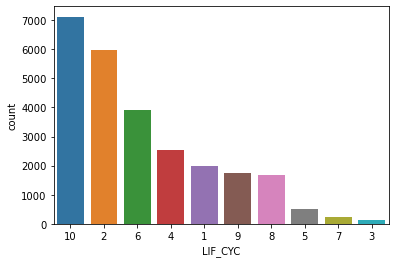

In [47]:
cat_col_prop(x_train,"LIF_CYC")

# No major disproportion

## 3. One-Hot- Encoding

In [48]:
x_train.dtypes

R_AGE                 int64
EDUC                  int64
R_RACE                int64
R_SEX                 int64
WRK_HOME              int64
WKFTPT                int64
OCCAT                 int64
DRIVER                int64
TRAVDAY               int64
HH_CBSA              object
HOMEOWN               int64
HHSIZE               object
HHVEHCNT             object
HHFAMINC              int64
NUMADLT             float64
YOUNGCHILD          float64
WRKCOUNT            float64
MSACAT                int64
MSASIZE               int64
URBAN                object
URBANSIZE             int64
URBRUR                int64
LIF_CYC               int64
AGE_bins             object
NUMADLT_ratio        object
YOUNGCHILD_ratio     object
WRKCOUNT_ratio       object
dtype: object

In [49]:
to_obj = ['EDUC','R_RACE','AGE_bins','HHFAMINC','HOMEOWN','R_SEX','TRAVDAY','WRK_HOME','WKFTPT','OCCAT','DRIVER','MSACAT','MSASIZE','URBAN','URBANSIZE','URBRUR','LIF_CYC']

x_train[to_obj] = x_train[to_obj].astype(str)
x_test[to_obj]= x_test[to_obj].astype(str)

x_train.drop(['R_AGE'], axis = 1, inplace =True)
x_test.drop(['R_AGE'],axis = 1, inplace = True)

In [50]:
one_hot_col = [c for c in x_train if x_train[c].dtypes == 'O' ]
x_train = pd.concat([x_train,pd.get_dummies(x_train[one_hot_col],prefix = one_hot_col)],axis = 1)
x_train.drop(one_hot_col, axis = 1, inplace = True)

x_test = pd.concat([x_test,pd.get_dummies(x_test[one_hot_col],prefix = one_hot_col)],axis = 1)
x_test.drop(one_hot_col, axis = 1, inplace = True)

In [51]:

#y_train = y_train.astype('int64')
#y_test = y_test.astype('int64')

In [52]:
#drop all negative value columns  

na_cols_train =[c for c in x_train if ('NA' in c) or ('-' in c)]

x_train.drop(na_cols_train, axis = 1, inplace = True)


na_cols_test =[c for c in x_test if ('NA' in c) or ('-' in c)]
x_test.drop(na_cols_test, axis = 1 , inplace = True)

In [53]:
x_train.shape

(25833, 108)

In [54]:
x_test.shape

(6459, 108)

In [65]:
x_train

,R_AGE,HOMEOWN,HHFAMINC,NUMADLT,YOUNGCHILD,WRKCOUNT,EDUC_1,EDUC_2,EDUC_3,EDUC_4,...,NUMADLT_ratio_1,NUMADLT_ratio_<0.5,NUMADLT_ratio_>0.5,YOUNGCHILD_ratio_0,YOUNGCHILD_ratio_<0.5,YOUNGCHILD_ratio_>0.5,WRKCOUNT_ratio_0,WRKCOUNT_ratio_1,WRKCOUNT_ratio_<0.5,WRKCOUNT_ratio_>0.5
11231,61,1,5,1.00,0.0,0.50,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
30915,62,2,4,0.75,0.0,0.25,0,0,1,0,...,0,0,1,1,0,0,0,0,1,0
2930,32,2,8,1.00,0.0,1.00,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
11668,39,2,7,1.00,0.0,1.00,0,0,0,1,...,1,0,0,1,0,0,0,1,0,0
10139,80,1,5,1.00,0.0,0.00,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5270,15,2,-7,0.60,0.0,0.40,1,0,0,0,...,0,0,1,1,0,0,0,0,1,0
25839,78,1,4,1.00,0.0,0.50,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
14829,50,1,-8,1.00,0.0,0.00,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0
1946,27,1,7,1.00,0.0,1.00,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0


## Models

### Linear Regression

In [61]:
#Checking for multicollinearity through variance Inflation Factor 
#VIF=1, Very Less Multicollinearity
#VIF<5, Moderate Multicollinearity
#VIF>5, Extreme Multicollinearity (This is what we have to avoid)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model, model_selection, metrics


In [62]:
LRmodel = linear_model.LinearRegression()  #create the linear regression 
LRmodel.fit(x_train,y_train) #train the model using the training set 
LR_pred = LRmodel.predict(x_test) #use this model to predict the test data set 

In [63]:
print('R^2 score:\t\t\t\t',LRmodel.score(x_test, y_test)) #compute R^2 score 
print('Explained Variance: \t\t\t', metrics.explained_variance_score(y_test, LR_pred)) #compute explained variance score
print('Mean Absolute Error: \t\t\t', metrics.mean_absolute_error(y_test, LR_pred)) #compute MAE results
print('Mean Squared Error:\t\t\t', metrics.mean_squared_error(y_test, LR_pred)) #compute MSE results
print('Root Mean Squared Error:\t\t', metrics.mean_squared_error(y_test, LR_pred, squared = False)) #compute RSME results
print('Intercept:\t', LRmodel.intercept_) #find intercept value 
print('Coef:\t', np.sum(LRmodel.coef_!=0))#find no of features used in regression model 

R^2 score:				 0.07700350664807853
Explained Variance: 			 0.07703606896249415
Mean Absolute Error: 			 1.9617563271293612
Mean Squared Error:			 6.304798292366382
Root Mean Squared Error:		 2.5109357403897024
Intercept:	 1.6987125455350351
Coef:	 89


In [78]:
#x_train_sm= sm.add_constant(x_train)
#ls=sm.OLS(y_train,x_train_sm).fit()
#print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:                n_trips   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     35.77
Date:                Mon, 26 Jul 2021   Prob (F-statistic):               0.00
Time:                        22:43:03   Log-Likelihood:                -60271.
No. Observations:               25833   AIC:                         1.207e+05
Df Residuals:                   25763   BIC:                         1.213e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.36

<AxesSubplot:xlabel='n_trips'>

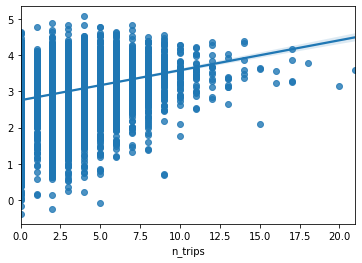

In [66]:
sns.regplot(y_test,LR_pred) #plotting predictions 

In [64]:
#calculate VIF scores to detect multicolinearity 

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x_train.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train.values, i)
                          for i in range(len(x_train.columns))]
  
print(vif_data)

                  feature        VIF
0                   R_AGE   3.220314
1                 HOMEOWN   1.016740
2                HHFAMINC   1.281461
3                 NUMADLT  28.878423
4              YOUNGCHILD  20.225509
..                    ...        ...
84  YOUNGCHILD_ratio_>0.5        inf
85       WRKCOUNT_ratio_0        inf
86       WRKCOUNT_ratio_1        inf
87    WRKCOUNT_ratio_<0.5        inf
88    WRKCOUNT_ratio_>0.5        inf

[89 rows x 2 columns]


In [70]:
vif_data.sort_values(by = 'VIF', ascending = False)

,feature,VIF
44,HHSIZE_3,inf
45,HHSIZE_>3,inf
65,URBANSIZE_5,inf
64,URBANSIZE_3,inf
63,URBANSIZE_2,inf
...,...,...
0,R_AGE,3.220314
14,R_RACE_4,1.443451
2,HHFAMINC,1.281461
15,R_RACE_5,1.150081


In [75]:
# counting number of infinity features 

vif_data_inf = np.isinf(vif_data['VIF']).values.sum()
print("It contains " + str(vif_data_inf) + " infinite values")

It contains 58 infinite values


#### PCA - dimension reduction

### Random Forest

In [56]:
from sklearn import tree, ensemble, model_selection, metrics

rforest = ensemble.RandomForestRegressor(n_estimators = 1000, max_features = 50, oob_score = True, random_state = 2019)
rforest.fit(x_train, y_train)


RandomForestRegressor(max_features=50, n_estimators=1000, oob_score=True,
                      random_state=2019)

In [57]:
rforest.score(x_test, y_test)

0.06210182558203847

In [58]:
x_test.shape

(6459, 108)

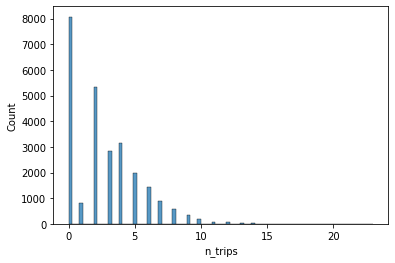

In [59]:
sns.histplot(data = y_train)

In [60]:
[c for c in x_train]

['NUMADLT',
 'YOUNGCHILD',
 'WRKCOUNT',
 'EDUC_1',
 'EDUC_2',
 'EDUC_3',
 'EDUC_4',
 'EDUC_5',
 'R_RACE_1',
 'R_RACE_2',
 'R_RACE_3',
 'R_RACE_4',
 'R_RACE_5',
 'R_RACE_6',
 'R_RACE_97',
 'R_SEX_1',
 'R_SEX_2',
 'WRK_HOME_1',
 'WRK_HOME_2',
 'WKFTPT_1',
 'WKFTPT_2',
 'OCCAT_1',
 'OCCAT_2',
 'OCCAT_3',
 'OCCAT_4',
 'OCCAT_97',
 'DRIVER_1',
 'DRIVER_2',
 'TRAVDAY_1',
 'TRAVDAY_2',
 'TRAVDAY_3',
 'TRAVDAY_4',
 'TRAVDAY_5',
 'TRAVDAY_6',
 'TRAVDAY_7',
 'HH_CBSA_15380',
 'HH_CBSA_35620',
 'HH_CBSA_40380',
 'HH_CBSA_XXXXX',
 'HOMEOWN_1',
 'HOMEOWN_2',
 'HOMEOWN_97',
 'HHSIZE_1',
 'HHSIZE_2',
 'HHSIZE_3',
 'HHSIZE_>3',
 'HHVEHCNT_1',
 'HHVEHCNT_2',
 'HHVEHCNT_3',
 'HHVEHCNT_>3',
 'HHFAMINC_1',
 'HHFAMINC_10',
 'HHFAMINC_11',
 'HHFAMINC_2',
 'HHFAMINC_3',
 'HHFAMINC_4',
 'HHFAMINC_5',
 'HHFAMINC_6',
 'HHFAMINC_7',
 'HHFAMINC_8',
 'HHFAMINC_9',
 'MSACAT_1',
 'MSACAT_2',
 'MSACAT_3',
 'MSACAT_4',
 'MSASIZE_1',
 'MSASIZE_2',
 'MSASIZE_3',
 'MSASIZE_4',
 'MSASIZE_5',
 'MSASIZE_6',
 'URBAN_rural',
